<img src="images/rl.jpg" align=right width=50%></img>
# Reinforcement Learning
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [TD-learning](#TD-learning)
- [Q-learning](#Q-learning)
- [REINFORCE](#REINFORCE)
- [Actor-critic](#Actor-critic)

**Note**: this notebook covers basics and fundamentals of [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning). Believe me when I say this only covers basics because all of these implementations are simple enough to run on a Chromebook. More advanced and state of the art RL algorithms will be explored in separate notebooks.

In [1]:
import gym
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Categorical
from torchsummary import summary
from IPython import display

In [2]:
%matplotlib notebook

## TD-learning

Invented by Arthur Samuel (who supposedly coined the term "machine learning"!), Temporal difference learning (**TD-learning**) is a class of reinforcement learning methods that learn by bootstrapping from the current estimate of the value function. TD value learning seems to be the most minimal embodiment of the most fundamental concept in reinforcement learning, which is **maximization of expected sum of rewards**. The learning rule is described as follows,

$$
V(s_t) \leftarrow (1 - \alpha)V(s_t) + \alpha(r_t + \gamma V(s_{t + 1}))
$$

which can also be written as 

$$
V(s_t) \leftarrow V(s_t) + \alpha(r_t + \gamma V(s_{t + 1}) - V(s_t))
$$

where $r_t + \gamma V(s_{t + 1})$ is the *TD target*.

Note: I also want to emphasize that TD-learning is a *class* of learning algorithms, even though we use the term here for referring to learning the value function. In other words, other temporal difference methods such as Q-learning, SARSA, and TD-$\lambda$ are all TD-learning methods.

In [ ]:
# TODO: implement TD value learning

## Q-learning

TD value learning suggests a nice approach to estimate values of explored states, but it's basically useless in the context of unknown MDPs, since it doesn't provide any information on what action should be taken at a state. **Q-learning** is a TD-learning method that learns the action-value function, $Q(S, A)$, rather than the state-value function, $V(S)$. In such way, the agent can decide *which action to take*, without having to know the transition model. The learning rule is as follows,

$$
Q(s_t, a_t) \leftarrow (1 - \alpha)Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a))
$$

which, once again, can be rewritten as

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha(r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t))
$$

where the term $r_t + \gamma \max_{a}Q(s_{t + 1}, a) - Q(s_t, a_t)$ directly describes the "error" in Q values.

In [3]:
def update_q(q_table, obs, action, reward, next_obs, alpha, gamma):
    diff = reward + gamma * np.max(q_table[next_obs, :]) - q_table[obs, action]
    q_table[obs, action] = q_table[obs, action] + alpha * diff

In [4]:
def q_learning(q_table, env, alpha, gamma, epsilon, n_iters, n_eps):
    ep_log = [] # record length and total reward of each episode
    for ep in tqdm(range(n_eps)):
        obs = env.reset()
        i = total_reward = done = 0
        while not done and i < n_iters:
            # ε-greedy is applied for exploration, in which by some probability ε,
            # a random action is chosen, instead of the reward maximizing action.
            action = np.random.choice([env.action_space.sample(), np.argmax(q_table[obs, :])],
                                      p=[epsilon, 1 - epsilon])
            next_obs, reward, done, _ = env.step(action)
            update_q(q_table, obs, action, reward, next_obs, alpha, gamma)
            total_reward += reward
            obs = next_obs
            i += 1
        ep_log.append((i, total_reward))
    return ep_log

For this section, we're going to use a simple Grid World based environment called **Frozen Lake**.

In [5]:
env = gym.make("Taxi-v2")
print(env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


In [6]:
q_table = np.zeros((env.observation_space.n, env.action_space.n))
ep_log = q_learning(q_table, env, 0.1, 0.9, 0.2, 200, 2000)
durations, total_rewards = zip(*ep_log)

<IPython.core.display.Javascript object>


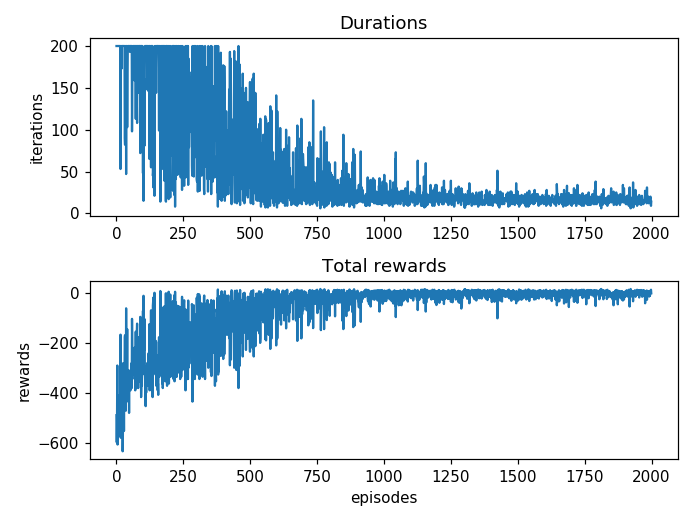

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title("Durations")
ax1.set_ylabel("iterations")
ax1.plot(durations)

ax2.set_title("Total rewards")
ax2.set_ylabel("rewards")
ax2.plot(total_rewards)

plt.xlabel("episodes")
plt.tight_layout()
plt.show()

In [8]:
obs = env.reset()
done = False
while not done:
    env.render()
    action = np.argmax(q_table[obs, :])
    obs, reward, done, info = env.step(action)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : :_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+

That was fun and all, but Q-learning (or even its [deep learning varient from DeepMind](https://deepmind.com/research/dqn/), which is explored in a different notebook) turned out to be not so useful, as it can't be used for continuous control tasks. Policy optimization, which optimizes the agent's policy directly, is currently a popular alternative. There are several classes of policy optimization methods, including [evolutionary algorithms](https://blog.openai.com/evolution-strategies/), but in this notebook, we'll focus on gradient-based methods, namely **policy gradient** methods.

## REINFORCE

Among various policy gradient methods, **REINFORCE** (**RE**ward **I**ncrement = **N**onnegative **F**actor times **O**ffset **R**einforcement times **C**haracter **E**ligibility; *I know, may this terrible acronym never come up again*), is the most naive. The core idea of this algorithm is the following update rule:

$$
\theta_{t + 1} \leftarrow \theta_t + \alpha \gamma^t G_t \nabla J(\theta)
$$

where 
$$
\nabla J(\theta) = \frac{\nabla\pi(A_t \big\lvert S_t, \theta_t)}{\pi(A_t \big\lvert S_t, \theta_t)} = \nabla \ln{\pi(A_t \big\lvert S_t, \theta_t)}
$$

Since we're going to use PyTorch here and on, we need some configurations.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cpu


In [10]:
env = gym.make("CartPole-v1") # some continuous control task
print(env.observation_space)
print(env.action_space)
print(env.spec.reward_threshold)

Box(4,)
Discrete(2)
475.0


In [11]:
class Policy(nn.Module):
    def __init__(self, in_features, action_dim):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)

In [12]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
summary(Policy(obs_dim, act_dim).to(device), (obs_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
            Linear-2                    [-1, 2]             258
Total params: 898
Trainable params: 898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [13]:
def sel_action(act_probs):
    dist = Categorical(act_probs)
    action = dist.sample()
    return action.item(), dist.log_prob(action)

In [14]:
def expected_returns(rewards, gamma):
    returns = [0.0]
    for i, r in enumerate(reversed(rewards)):
        returns.append(r + gamma * returns[i])
    returns = torch.tensor(list(reversed(returns[1:])))
    return (returns - returns.mean()) / (returns.std() + 1e-8)

In [70]:
def reinforce(env, policy, alpha, gamma, n_steps, n_eps, device):
    ep_log = []
    optimizer = optim.Adam(policy.parameters(), lr=alpha)
    for i in tqdm(range(n_eps)):
        log_probs = []
        rewards = []
        gammas = []
        
        # collect data via exploration
        obs = env.reset()
        t = done = 0
        while not done and t < n_steps:
            obs = torch.tensor(obs).float().to(device)
            action, log_prob = sel_action(policy(obs))
            obs, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            gammas.append(gamma ** t)
            t += 1
        
        # update parameters of the policy network
        optimizer.zero_grad()
        log_probs = torch.stack(log_probs)
        returns = expected_returns(rewards, gamma).to(device)
        gammas = torch.tensor(gammas).to(device)
        # NOTE: since returns are independent of the policy, they can be
        # a part of the loss without affecting the derivation
        loss = torch.dot(gammas * returns, -log_probs)
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
        optimizer.step()
        
        ep_log.append((t, sum(rewards)))
    return ep_log

In [71]:
policy = Policy(obs_dim, act_dim).to(device)
ep_log = reinforce(env, policy, 3e-3, 0.99, 500, 500, device)
durations, total_rewards = zip(*ep_log)

In [72]:
def plot_rewards(durations, total_rewards):
    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.set_title("Durations")
    ax1.set_ylabel("iterations")
    ax1.plot(durations)

    ax2.set_title("Total rewards")
    ax2.set_ylabel("rewards")
    ax2.plot(total_rewards)

    plt.xlabel("episodes")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


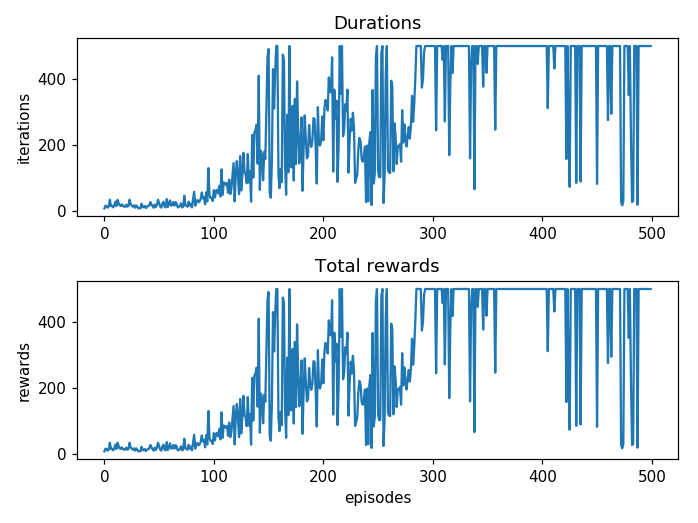

In [73]:
plot_rewards(durations, total_rewards)

## Actor-critic

Actor-critic is an on-policy method similar to REINFORCE. Rather than simply relying on a policy function  (Actor) to estimate actions, it also consists of a value function (Critic) — which can be either a state-value function, $V(S)$, or an action-value function, $Q(S, A)$ — to assist the policy update by reducing gradient variance.

Note that Actor-critic is quite similar to REINFORCE with baseline (check [this article](https://www.quora.com/What-is-the-difference-between-policy-gradient-methods-and-actor-critic-methods) for a more detailed explanation), where a baseline can be some stationary values that are not affected by further experience, subtracted from the expected return; in cases where the baseline is a learned value from experience, it simply becomes a 'critic', leaving very little distinction with Actor-critic methods.

In [74]:
class ActorCriticPolicy(nn.Module):
    def __init__(self, in_features, action_dim):
        super(ActorCriticPolicy, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)
        
    def forward(self, input_):
        input_ = F.relu(self.fc1(input_))
        return F.softmax(self.actor(input_), dim=-1), self.critic(input_)

In [75]:
summary(ActorCriticPolicy(obs_dim, act_dim).to(device), (obs_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
            Linear-2                    [-1, 2]             258
            Linear-3                    [-1, 1]             129
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [76]:
def actorcritic(env, policy, alpha, gamma, n_steps, n_eps, device):
    ep_log = []
    optimizer = optim.Adam(policy.parameters(), lr=alpha)
    for i in tqdm(range(n_eps)):
        log_probs = []
        value_preds = []
        rewards = []
        gammas = []
        
        # collect data via exploration
        obs = env.reset()
        t = done = 0
        while not done and t < n_steps:
            obs = torch.tensor(obs).float().to(device)
            act_probs, value_pred = policy(obs)
            action, log_prob = sel_action(act_probs)
            obs, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            value_preds.append(value_pred)
            rewards.append(reward)
            gammas.append(gamma ** t)
            t += 1
        
        # update parameters of the policy network
        optimizer.zero_grad()
        log_probs = torch.stack(log_probs)
        value_preds = torch.cat(value_preds)
        returns = expected_returns(rewards, gamma).to(device)
        gammas = torch.tensor(gammas).to(device)
        # NOTE: value prediction by the critic head is used as a baseline
        policy_loss = torch.dot(returns - value_preds.detach(), -log_probs)
        value_loss = F.mse_loss(value_preds, returns)
        loss = policy_loss + value_loss
        loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
        optimizer.step()
        
        ep_log.append((t, sum(rewards)))
    return ep_log

In [77]:
policy = ActorCriticPolicy(obs_dim, act_dim).to(device)
ep_log = actorcritic(env, policy, 3e-3, 0.99, 500, 500, device)
durations, total_rewards = zip(*ep_log)

<IPython.core.display.Javascript object>


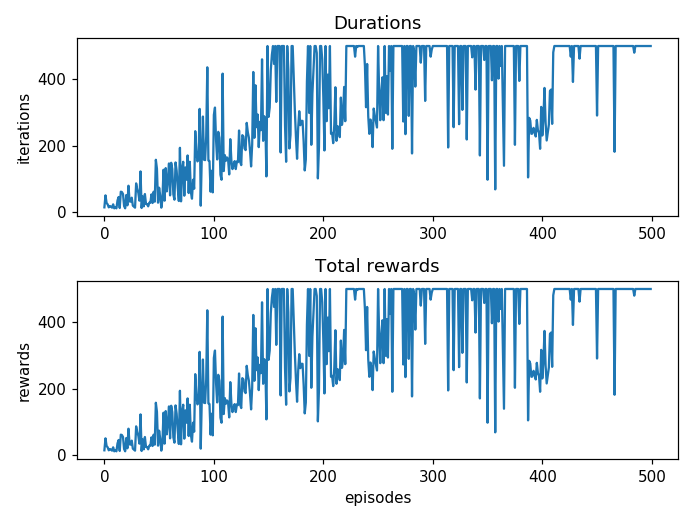

In [78]:
plot_rewards(durations, total_rewards)

## Model-based Reinforcement Learning

Coming soon!

## References

* https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0
* http://www.cs.utexas.edu/~sniekum/classes/343-S18/lectures/lecture11.pdf
* http://www.cs.utexas.edu/~sniekum/classes/343-S18/lectures/lecture12.pdf
* https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html